# M-Pesa Evolution in Kenya: Accounts, Revenue, and Usage Patterns (2015–2025)

Over the last decade, M-Pesa has solidified its position as Kenya’s leading mobile money platform, transforming payments, commerce, and financial inclusion. Active accounts continue to grow, but user acquisition has plateaued, shifting growth toward existing users. Revenue now drives a significant share of Safaricom’s total, though incremental gains are slowing as the platform matures. Transaction volume rises steadily, while average transaction value declines, reflecting a clear shift toward micro-payments. Merchant-led payments have overtaken cash agents, with Pochi emerging as the fastest-growing channel, now driving the majority of micro-commerce flows.

**Business Task:** Understand M-Pesa’s evolution in users, revenue, and transactions, identify ecosystem shifts, and pinpoint monetization opportunities.

**Dataset Source & Limitations:** Data comes from Safaricom annual reports (2015–2025) and includes active accounts, agent, merchant, and Pochi counts, total transactions and values, and revenue. Analysis is limited to Kenya, uses annual aggregates, and may be affected by missing fields or unverified company-reported figures. External factors such as macroeconomic changes or policy shifts are not captured.


In [1]:
#Setting up the environment
library(tidyverse)
library(scales)
library(patchwork)
library(lubridate)
library(readr)
library(ggplot2)

options(
  repr.plot.width = 22, 
  repr.plot.height = 10,
  repr.plot.res = 200
)

scale_factor <- 1.8

my_theme <- theme_minimal(base_size = 12 * scale_factor) +
  theme(
    axis.title.y  = element_text(size = 14 * scale_factor),
    axis.text     = element_text(size = 12 * scale_factor),
    plot.title    = element_text(size = 16 * scale_factor),
    legend.text   = element_text(size = 12 * scale_factor),
    axis.title.x  = element_blank(),
    panel.grid = element_blank(),     # removes major + minor gridlines
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "grey", linewidth = 0.4), # adds clean axis lines
    panel.border = element_blank()
  )




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
#Loading my Dataframe
safaricom_df <- read_csv("/kaggle/input/safaricom-mpesa-2015-to-2025/safaricom_mpesa_2015_2025.csv",
                         na = c("NA", "")) %>%
  # Year as integer
  mutate(year = as.integer(year)) %>%
  
  # Convert year_ending to Date
  mutate(year_ending = ymd(year_ending)) %>%
  
  # Remove commas and convert count columns to integer
  mutate(across(
    c(active_mpesa_accounts, agents, merchants, pochi),
    ~ as.integer(gsub(",", "", .))
  )) %>%
  
  # Remove commas and convert monetary/transaction columns to numeric
  mutate(across(
    c(total_transactions,total_value_kes, revenue_mpesa_kes, total_revenue_kes),
    ~ as.numeric(gsub(",", "", .))
  ))

Rows: 11 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): year
num  (8): active_mpesa_accounts, total_transactions, total_value_kes, agents...
date (1): year_ending

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Creating Derived Metrics
safaricom_df <- safaricom_df %>%
  arrange(year)%>%
  mutate(
    avg_volume = total_transactions / active_mpesa_accounts,
    avg_value  = total_value_kes / total_transactions,
    yoy_avg_volume = (avg_volume / lag(avg_volume) - 1) * 100,
    yoy_avg_value  = (avg_value / lag(avg_value) - 1) * 100,
    value_per_txn = total_value_kes / total_transactions,
    mpesa_revenue_share = revenue_mpesa_kes / total_revenue_kes * 100,
    non_mpesa_share = 100 - mpesa_revenue_share,
    accounts_growth = (active_mpesa_accounts / lag(active_mpesa_accounts) - 1) * 100, 
    txn_growth = total_transactions / lag(total_transactions) - 1,
    mpesa_rev_growth = (revenue_mpesa_kes - lag(revenue_mpesa_kes)) / lag(revenue_mpesa_kes) * 100,
    total_rev_growth = (total_revenue_kes - lag(total_revenue_kes)) / lag(total_revenue_kes) * 100
  )

In [4]:
#Defining my Plots

# Plot1 - active accounts over time
p1 <- ggplot(safaricom_df, aes(x = year, y = active_mpesa_accounts/1e6)) +
  geom_area(fill = "royalblue", alpha = 0.4) +
  geom_line(color = "royalblue", linewidth  = 1) +
  scale_x_continuous(breaks = seq(2015, 2025, by = 2)) +  # every 2 years
  labs(y = "Millions", title = "Active M-Pesa Accounts Over Time")   # Add title

#Plot2 --- YoY Growth - Active Accouts
plot2_df <- safaricom_df %>% filter(!is.na(accounts_growth))

p2 <- ggplot(plot2_df, aes(x = year, y = accounts_growth)) +
  geom_line(color = "royalblue", linewidth = 1.2) +
  geom_point(color = "royalblue", size = 2.5) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  scale_x_continuous(breaks = seq(2015, 2025, by = 2)) +  # every 2 years
  labs(
    title = "YoY % Growth: Active M-Pesa Accounts",
    y = NULL,
    x = NULL
  ) +
  annotate("text",
           x = 2025 - 4, y = safaricom_df$accounts_growth[safaricom_df$year == 2025] - 5,
           label = "19% to ~1%",
           color = "royalblue", size = 8, hjust = 1, vjust = -0.5) +
  annotate("segment",
           x = 2016, xend = 2024,
           y = safaricom_df$accounts_growth[safaricom_df$year == 2016],
           yend = safaricom_df$accounts_growth[safaricom_df$year == 2024],
           color = "royalblue", linewidth = 1.0, linetype = "dashed")


#plot3 - Mpesa Revenue as a % of Total Revenue
p3 <- ggplot(safaricom_df, aes(x = year)) +
  geom_area(aes(y = 100, fill = "Total Revenue"), color = NA) +
  geom_area(aes(y = mpesa_revenue_share, fill = "M-Pesa"), color = NA) +
  scale_fill_manual(
    values = c(
      "M-Pesa" = "royalblue",
      "Total Revenue" = "darkorange"
    )
  ) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +  
  scale_x_continuous(breaks = seq(2015, 2025, by = 2))+  # every 2 years
  labs(
    title = "M-Pesa as % of Total Safaricom Revenue",
    y = NULL,
    x = NULL,
    fill = NULL
  )


#plot4 - total revenue growth vs mpesa revenue growth YoY       
plot4_df <- safaricom_df %>% 
  filter(!is.na(mpesa_rev_growth)) %>% 
  select(year, mpesa_rev_growth, total_rev_growth) %>%
  pivot_longer(cols = c(mpesa_rev_growth, total_rev_growth),
               names_to = "series",
               values_to = "growth_pct")

p4 <- ggplot(plot4_df, aes(x = year, y = growth_pct, fill = series)) +
  geom_col(position = position_dodge(width = 0.65), width = 0.6) +
  scale_fill_manual(
    values = c("mpesa_rev_growth" = "royalblue", "total_rev_growth" = "darkorange"),
    labels = c("mpesa_rev_growth" = "M-Pesa", "total_rev_growth" = "Total")
  ) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  scale_x_continuous(breaks = seq(2015, 2025, 2)) +
  labs(
    title = "Revenue Growth: M-Pesa vs Total (YoY)",
    x = NULL, y = NULL, fill = NULL
  )

#Plot5 - Volume of transactions over time
p5 <- ggplot(safaricom_df %>% filter(!is.na(total_transactions)), 
       aes(x = year, y = total_transactions/1e9)) +
  geom_smooth(method = "loess", formula = y ~ x, se = FALSE, color = "royalblue", linewidth = 1.2) +
  geom_point(color = "royalblue", size = 2.5) +
  scale_x_continuous(breaks = safaricom_df$year)+
  labs(y = "Billions", title = "Volume of M-Pesa Transaction Trend") 

#Plot6 - Value of transactions over time
p6 <- ggplot(safaricom_df %>% filter(!is.na(total_value_kes)), 
       aes(x = year, y = total_value_kes /1e12)) +
  geom_smooth(method = "loess", formula = y ~ x, se = FALSE, color = "royalblue", linewidth = 1.2) +
  geom_point(color = "royalblue", size = 2.5) +
  scale_x_continuous(breaks = safaricom_df$year)+
  labs(y = "Trillions", title = "Value of M-Pesa Transaction Trend") 

# Plot 7 --- YoY % Growth of Avg Volume vs Avg Value ----
# Prepare the data
plot7_df <- safaricom_df %>%
  filter(!is.na(yoy_avg_volume), !is.na(yoy_avg_value)) %>%
  select(year, yoy_avg_volume, yoy_avg_value) %>%
  pivot_longer(
    cols = c(yoy_avg_volume, yoy_avg_value),
    names_to = "series",
    values_to = "value"
  ) %>%
  mutate(
    series = recode(series,
                    yoy_avg_volume = "Avg Volume",
                    yoy_avg_value  = "Avg Value")
  )
#Plot
p7 <- ggplot(plot7_df, aes(x = year, y = value, color = series)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 2.5) +
  scale_color_manual(values = c("Avg Volume" = "royalblue", "Avg Value" = "darkorange")) +
  scale_x_continuous(breaks = plot7_df$year) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  labs(
    title = "YoY % Transaction Growth: Avg Volume vs Avg Value",
    y = NULL,
    color = NULL
  ) +
  annotate("text",
           x = 2025, y = safaricom_df$yoy_avg_value[safaricom_df$year == 2025]+16,
           label = "YoY Avg value collapse: +21% to -27%",
           color = "darkorange", size =8, hjust = 0.9) +
  annotate("segment",
           x = 2021, xend = 2025,
           y = safaricom_df$yoy_avg_value[safaricom_df$year == 2021],
           yend = safaricom_df$yoy_avg_value[safaricom_df$year == 2025],
           color = "darkorange", linetype = "dashed", linewidth = 1.0, arrow = arrow(length = unit(0.18, "cm"))) +

  annotate("text",
           x = 2024, y = safaricom_df$yoy_avg_volume[safaricom_df$year == 2024]-11,
           label = "YoY Avg volume stays up: micro-payments dominate",
           color = "royalblue", size = 8, hjust = 0.8) +
  annotate("segment",
           x = 2021, xend = 2024,
           y = safaricom_df$yoy_avg_volume[safaricom_df$year == 2021],
           yend = safaricom_df$yoy_avg_volume[safaricom_df$year == 2024],
           color = "royalblue", linetype = "dashed", linewidth = 1.0, arrow = arrow(length = unit(0.18, "cm")))


#plot8 - Number of agents and merchants
# Prepare data
plot8_df <- safaricom_df %>%
  select(year, agents, merchants, pochi) %>%
    pivot_longer(cols = c(agents, merchants, pochi),
               names_to = "series",
               values_to = "count")

# Plot
p8 <- ggplot(plot8_df, aes(x = year, y = count/1e3, color = series)) +
    # Agents and Merchants - no filtering
  geom_line(data = plot8_df %>% filter(series %in% c("agents", "merchants")), 
            linewidth = 1.2) +
  geom_point(data = plot8_df %>% filter(series %in% c("agents", "merchants")), 
             size = 2.5) +

  # Pochi - filter out NA and 0
  geom_line(data = plot8_df %>% filter(series == "pochi", !is.na(count), count != 0),
            linewidth = 1.2) +
  geom_point(data = plot8_df %>% filter(series == "pochi", !is.na(count), count != 0),
             size = 2.5) +
  
  scale_color_manual(values = c(
    "pochi" = "forestgreen",
    "merchants" = "darkorange",
    "agents" = "royalblue"
  )) +
  scale_x_continuous(breaks = seq(2015, 2025, by = 2)) +  # every 2 years
  labs(
    y = "Count ('000)",
    title = "Agents, Merchants, and Pochi Wallets Over Time",
    color = NULL
  ) +
  annotate("text",
           x = 2024-1.5, y = safaricom_df$pochi[safaricom_df$year == 2024]/1e3,
           label = "Pochi doubles annually\nNow twice merchants",
           color = "forestgreen", size = 8, hjust = 0, vjust = -3) +

  annotate("text",
           x = 2022-0.5, y = safaricom_df$merchants[safaricom_df$year == 2022]/1e3,
           label = "Post-2021 merchants scale,\nbut Pochi outpaces merchants",
           color = "darkorange", size = 8, hjust = 1)

## M-Pesa User Base: Growth, But Maturing

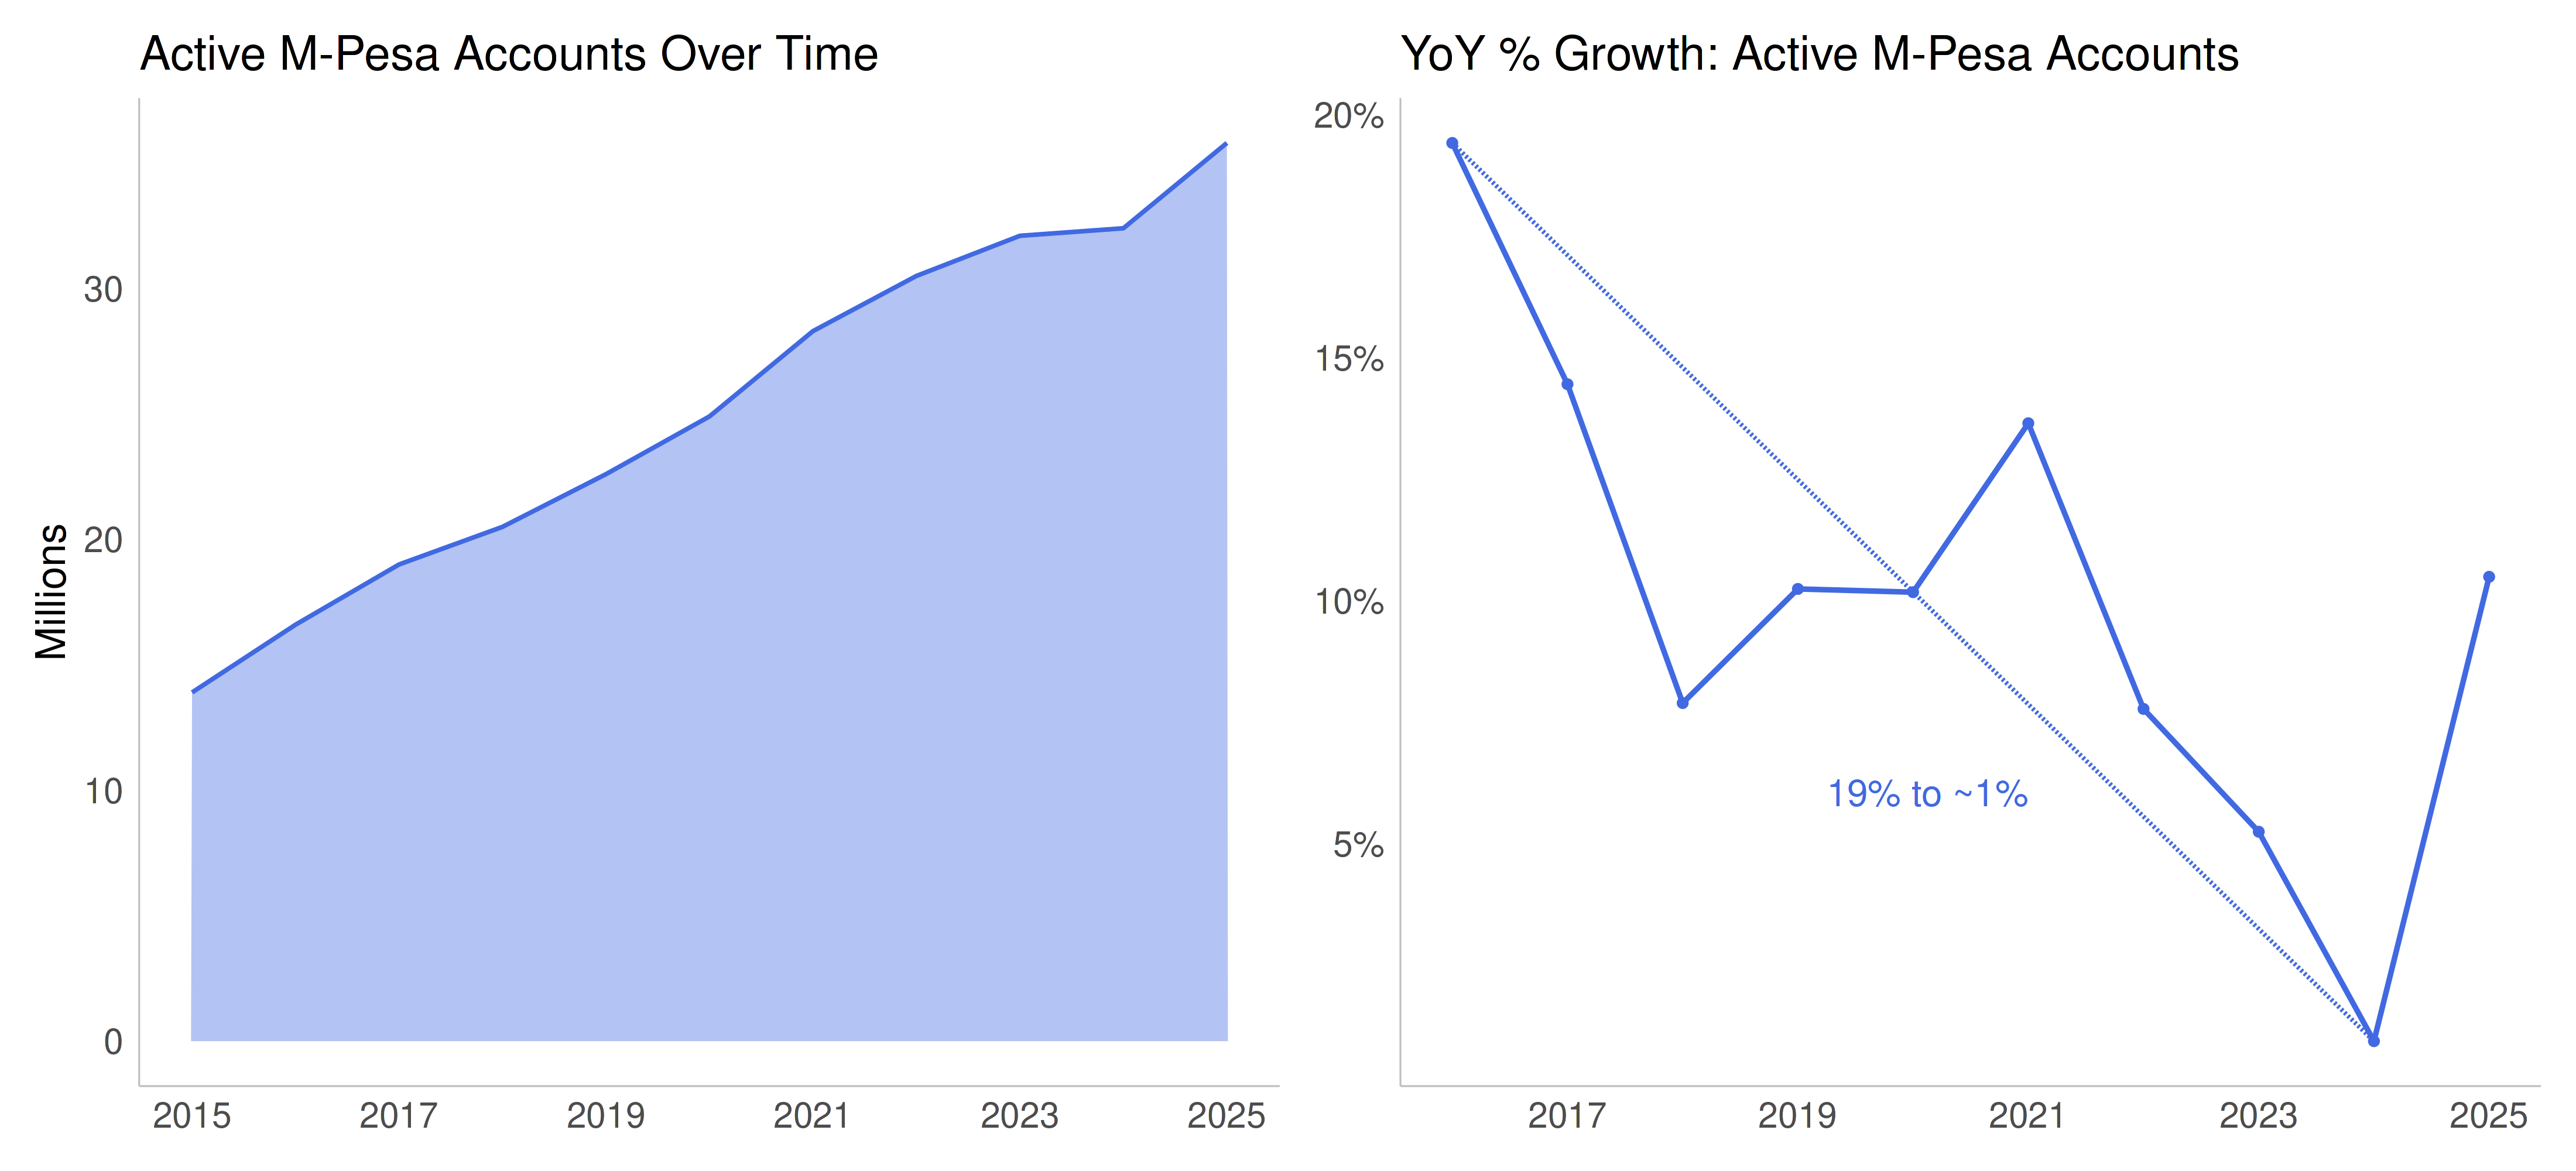

In [5]:
(p1| p2) + plot_layout(widths = c(1, 1)) &
theme(plot.margin = margin(20, 20, 20, 20)) &
my_theme


Active M-Pesa accounts have grown every year, but growth has slowed dramatically—from 19% year-on-year in 2015–2016 to around 1% in 2023–2024—before rebounding to 10% in 2024–2025. This shift signals that M-Pesa has moved from acquisition-driven expansion to a mature phase, where future revenue will rely on higher per-user monetization rather than adding new customers.


## Revenue: Expansion Driven by M-Pesa, Not Core Telco

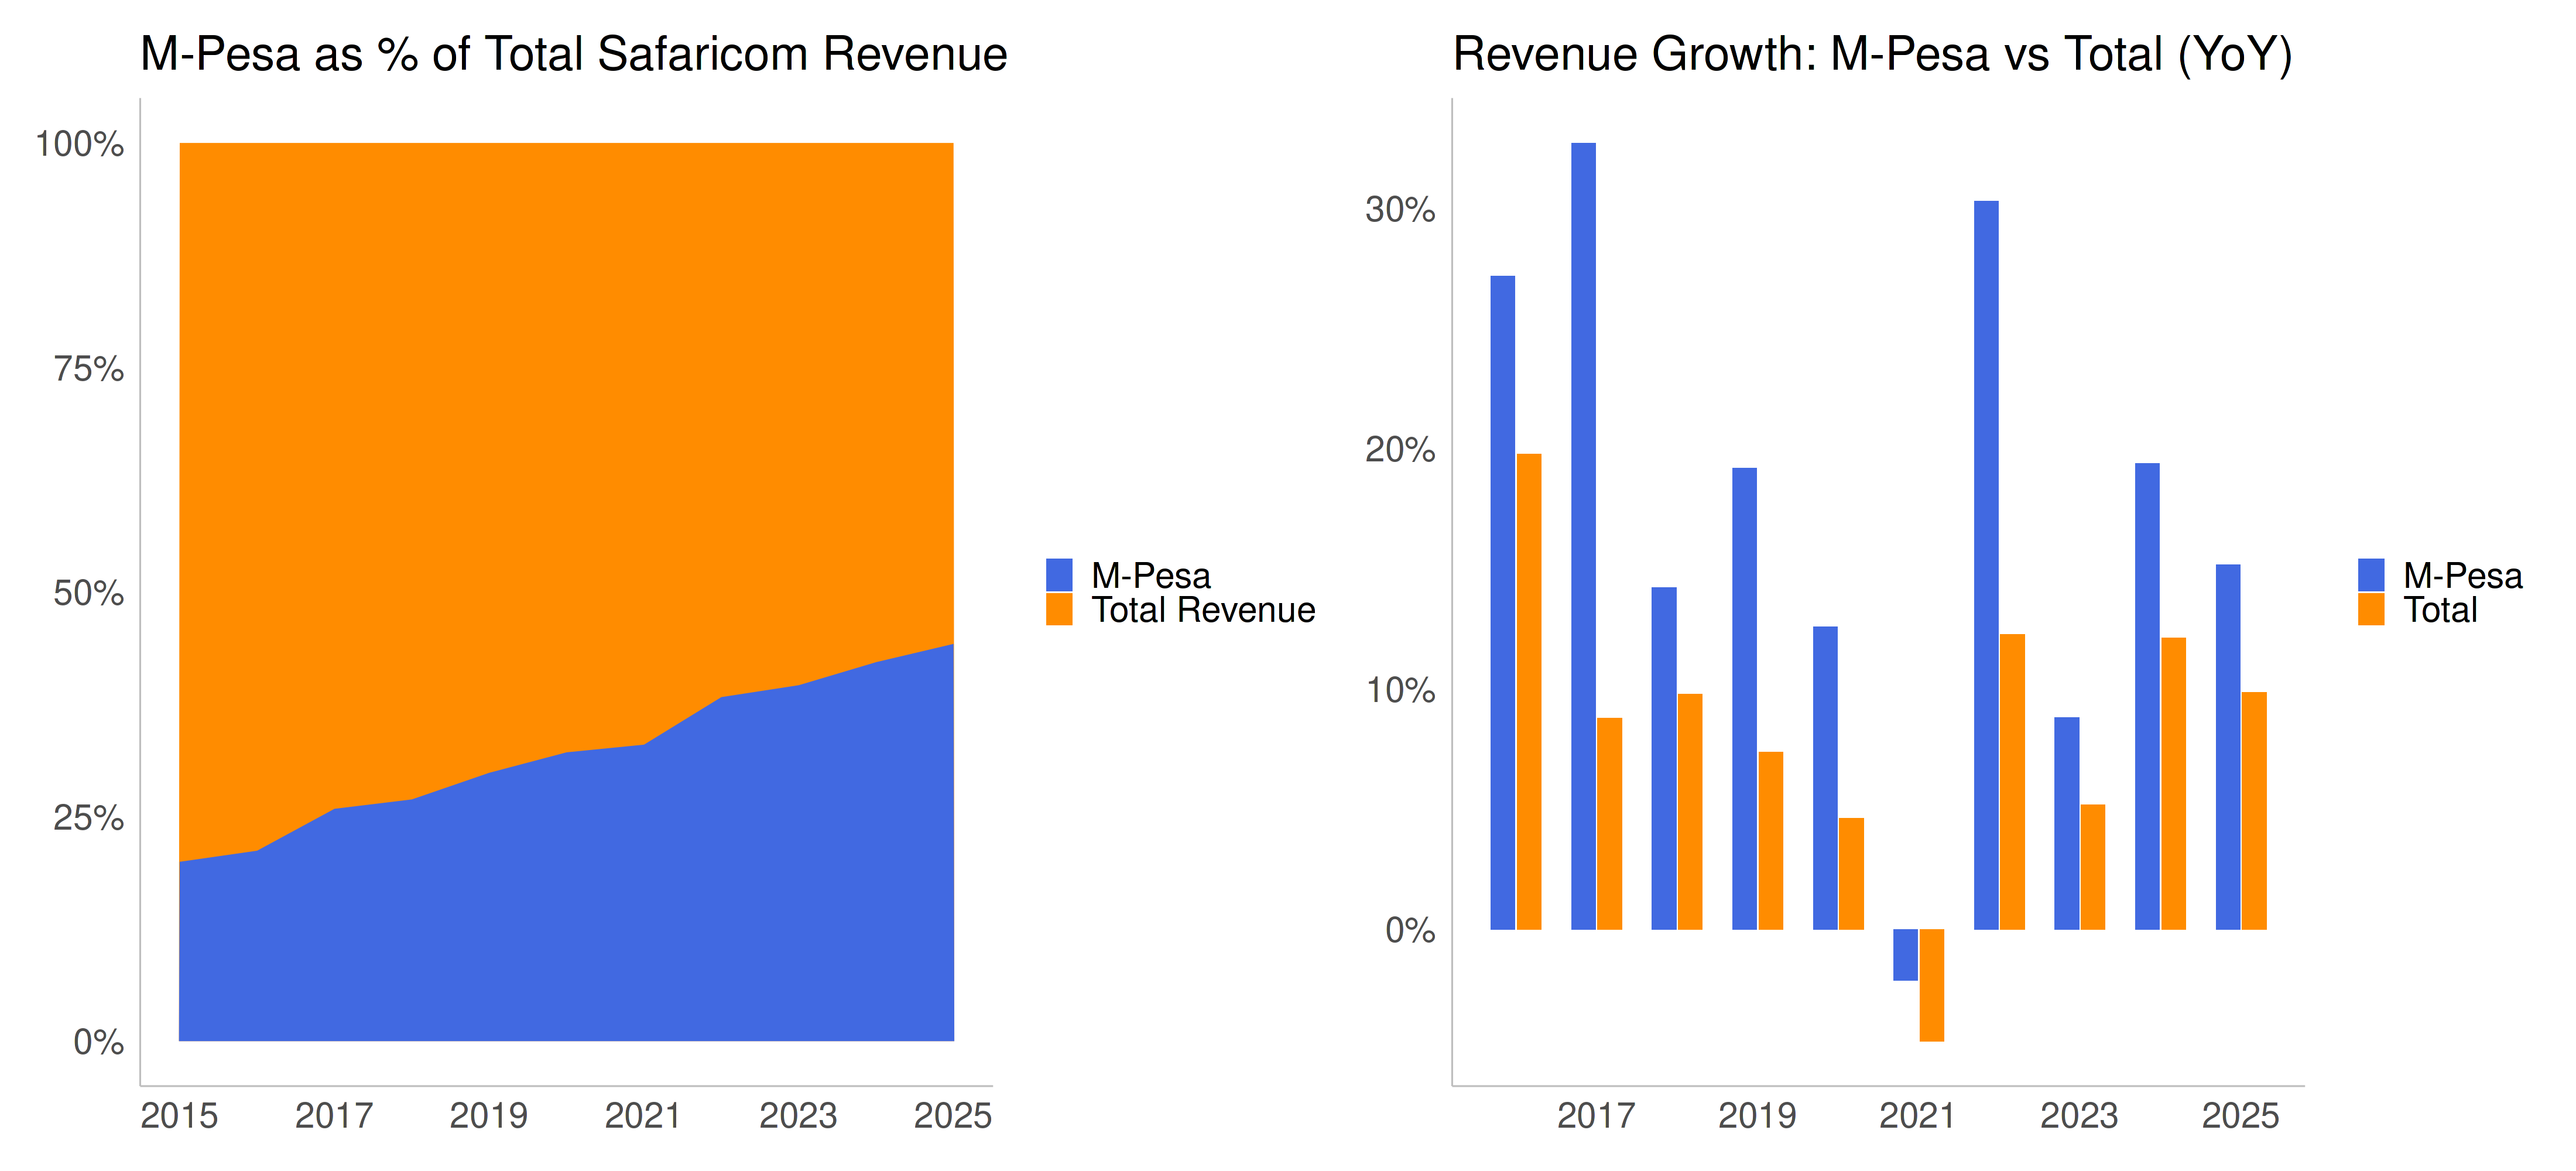

In [6]:
(p3 | p4) + plot_layout(widths = c(1, 1)) &
  theme(plot.margin = margin(20, 20, 20, 20))&
  my_theme

M-Pesa has become Safaricom’s growth engine, rising from 20% of total revenue in 2015 to 44% in 2025 and consistently outpacing overall business growth—33% vs 9% in 2017 and 30% vs 12% in 2022. The growth gap is now narrowing to 4–7% (2023–2025), signaling that M-Pesa is entering a mature phase where future gains will be harder to achieve.


## Transactions: More, Smaller

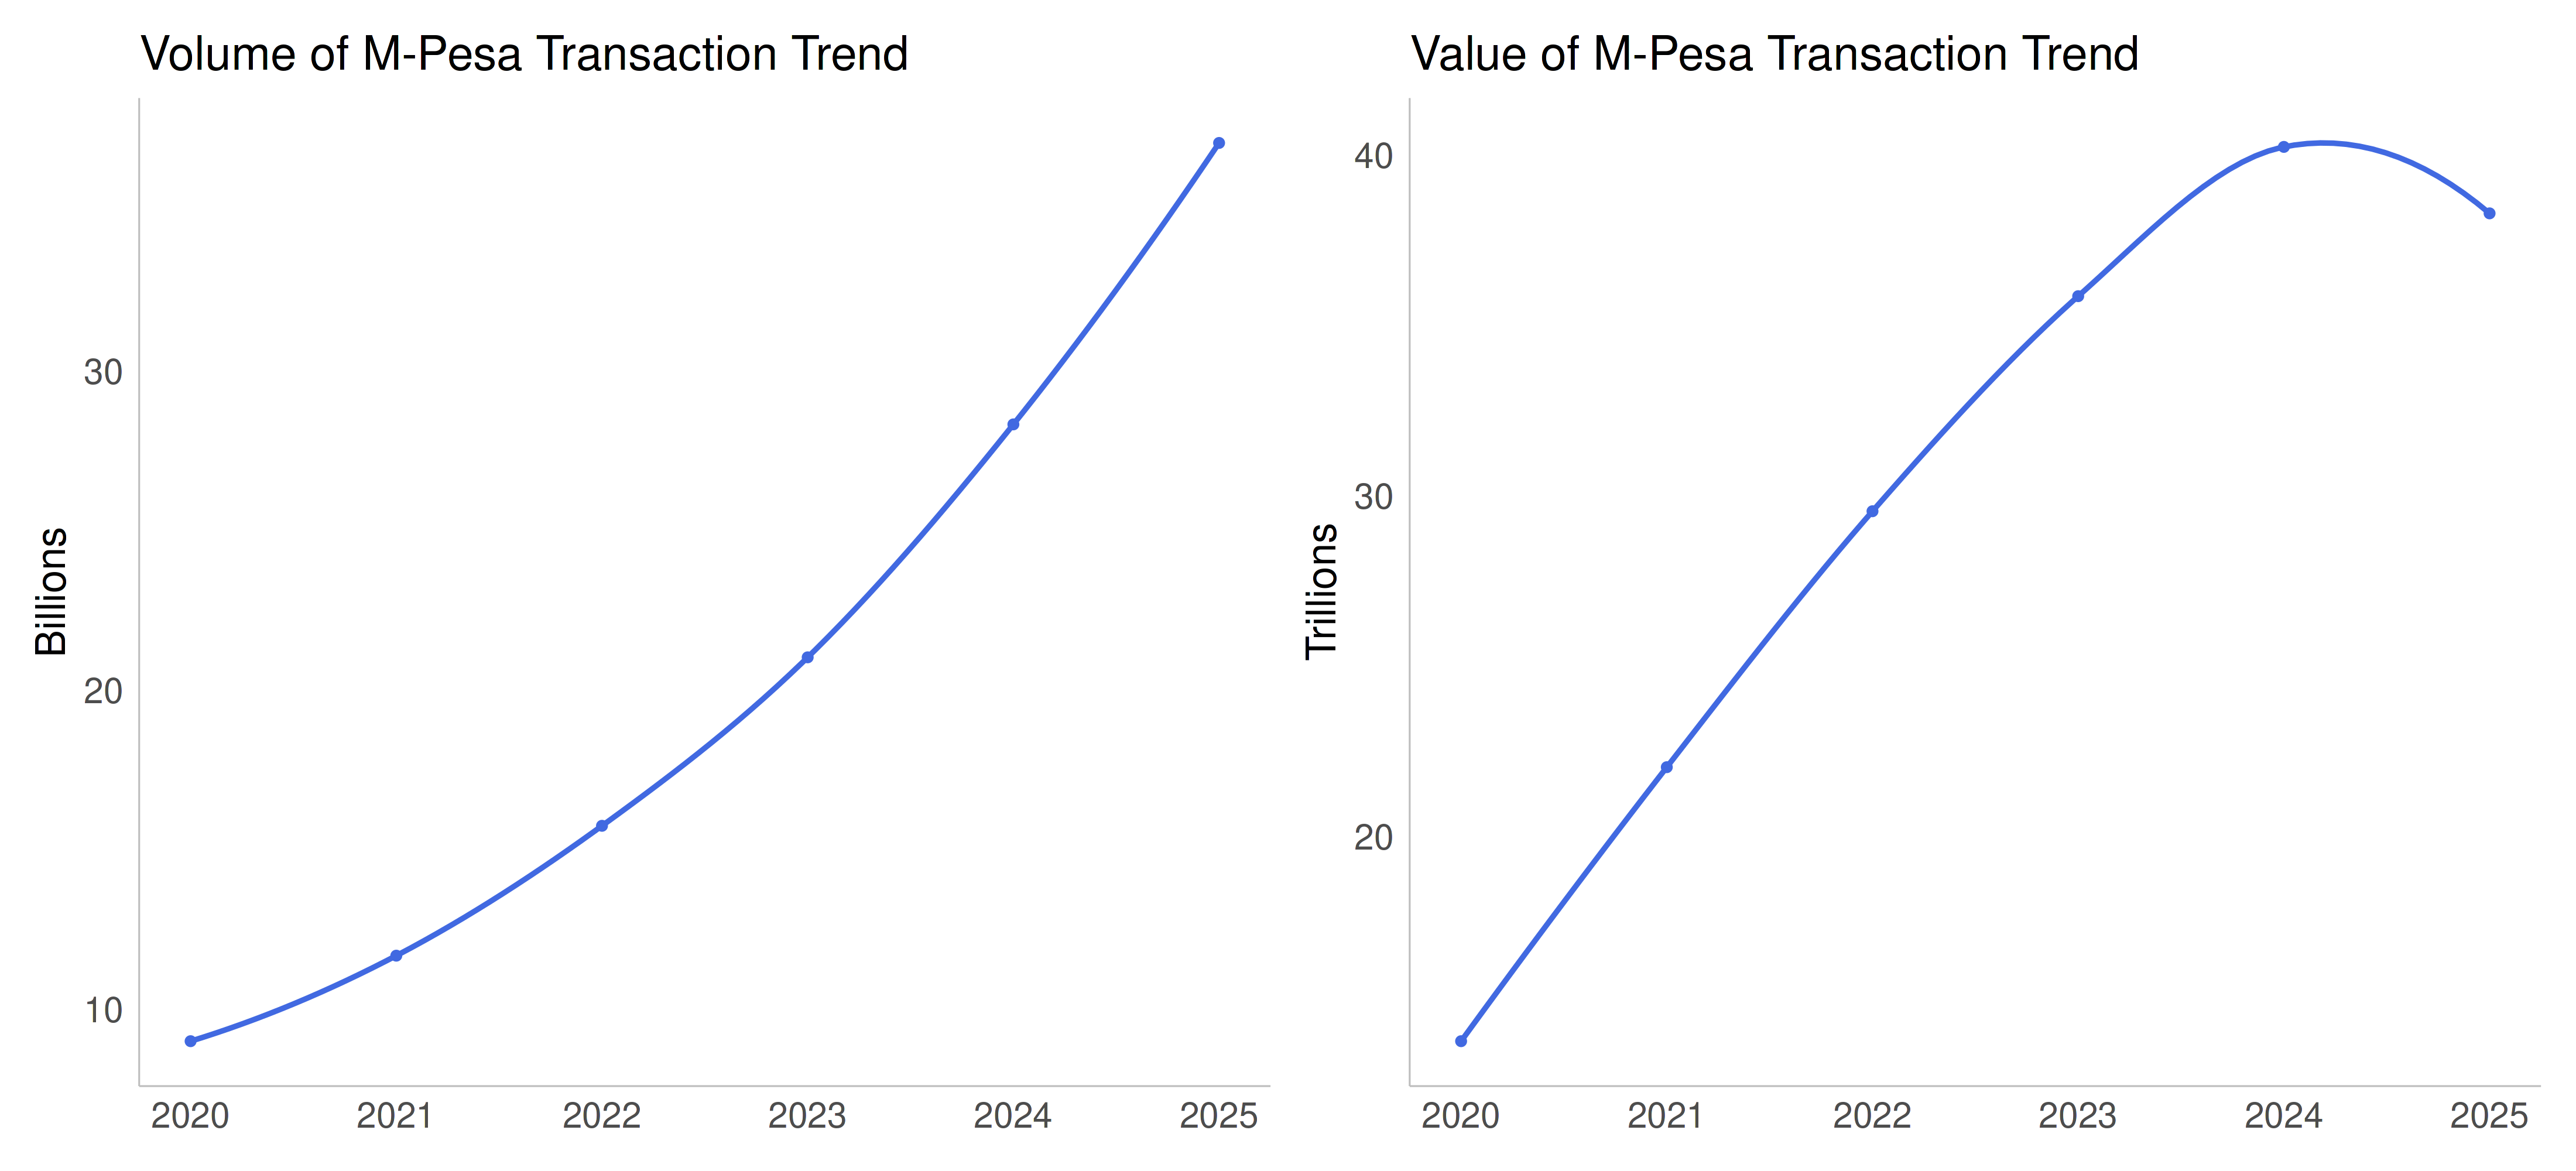

In [7]:
(p5 | p6) + plot_layout(widths = c(1, 1)) &
  theme(plot.margin = margin(20, 20, 20, 20)) & 
  my_theme

Transaction volume on M-Pesa continues to rise, but total value growth has stalled and even declined from 2024 onward.

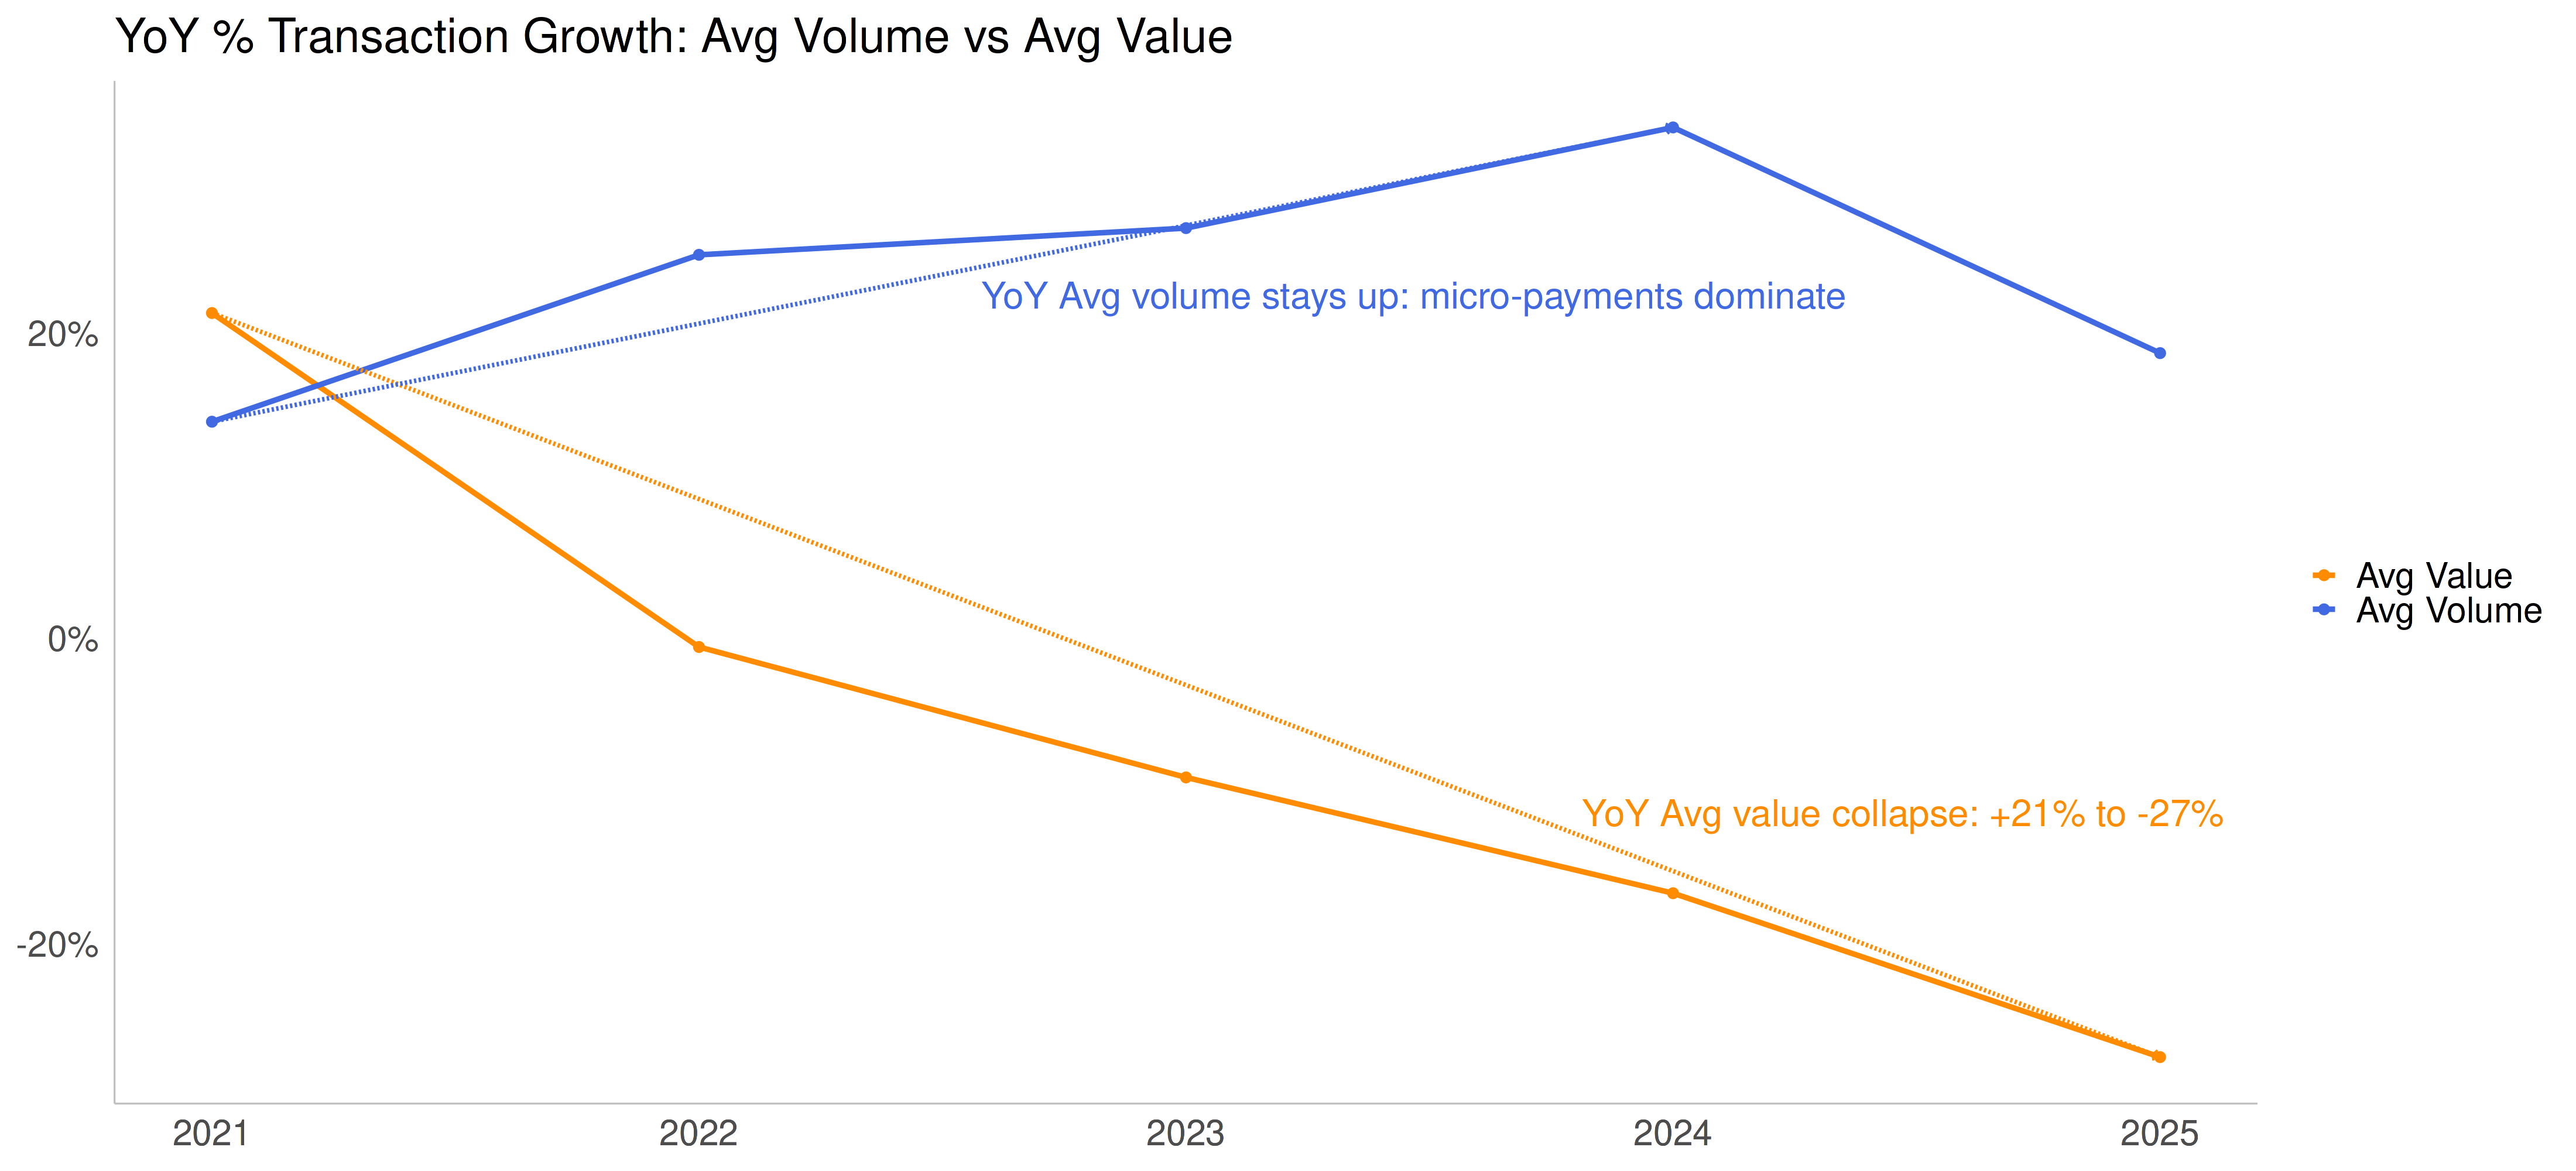

In [8]:
p7 + theme(plot.margin = margin(20, 20, 20, 20)) & 
  my_theme


Average transaction value growth dropped from +21% to −27% year-on-year. The platform is seeing more frequent, smaller transactions, reflecting a shift toward low-value, high-frequency payments. Future revenue growth will depend on efficiently monetizing these micro-transactions rather than relying on large transfers.

## M-Pesa Business Ecosystem Restructuring

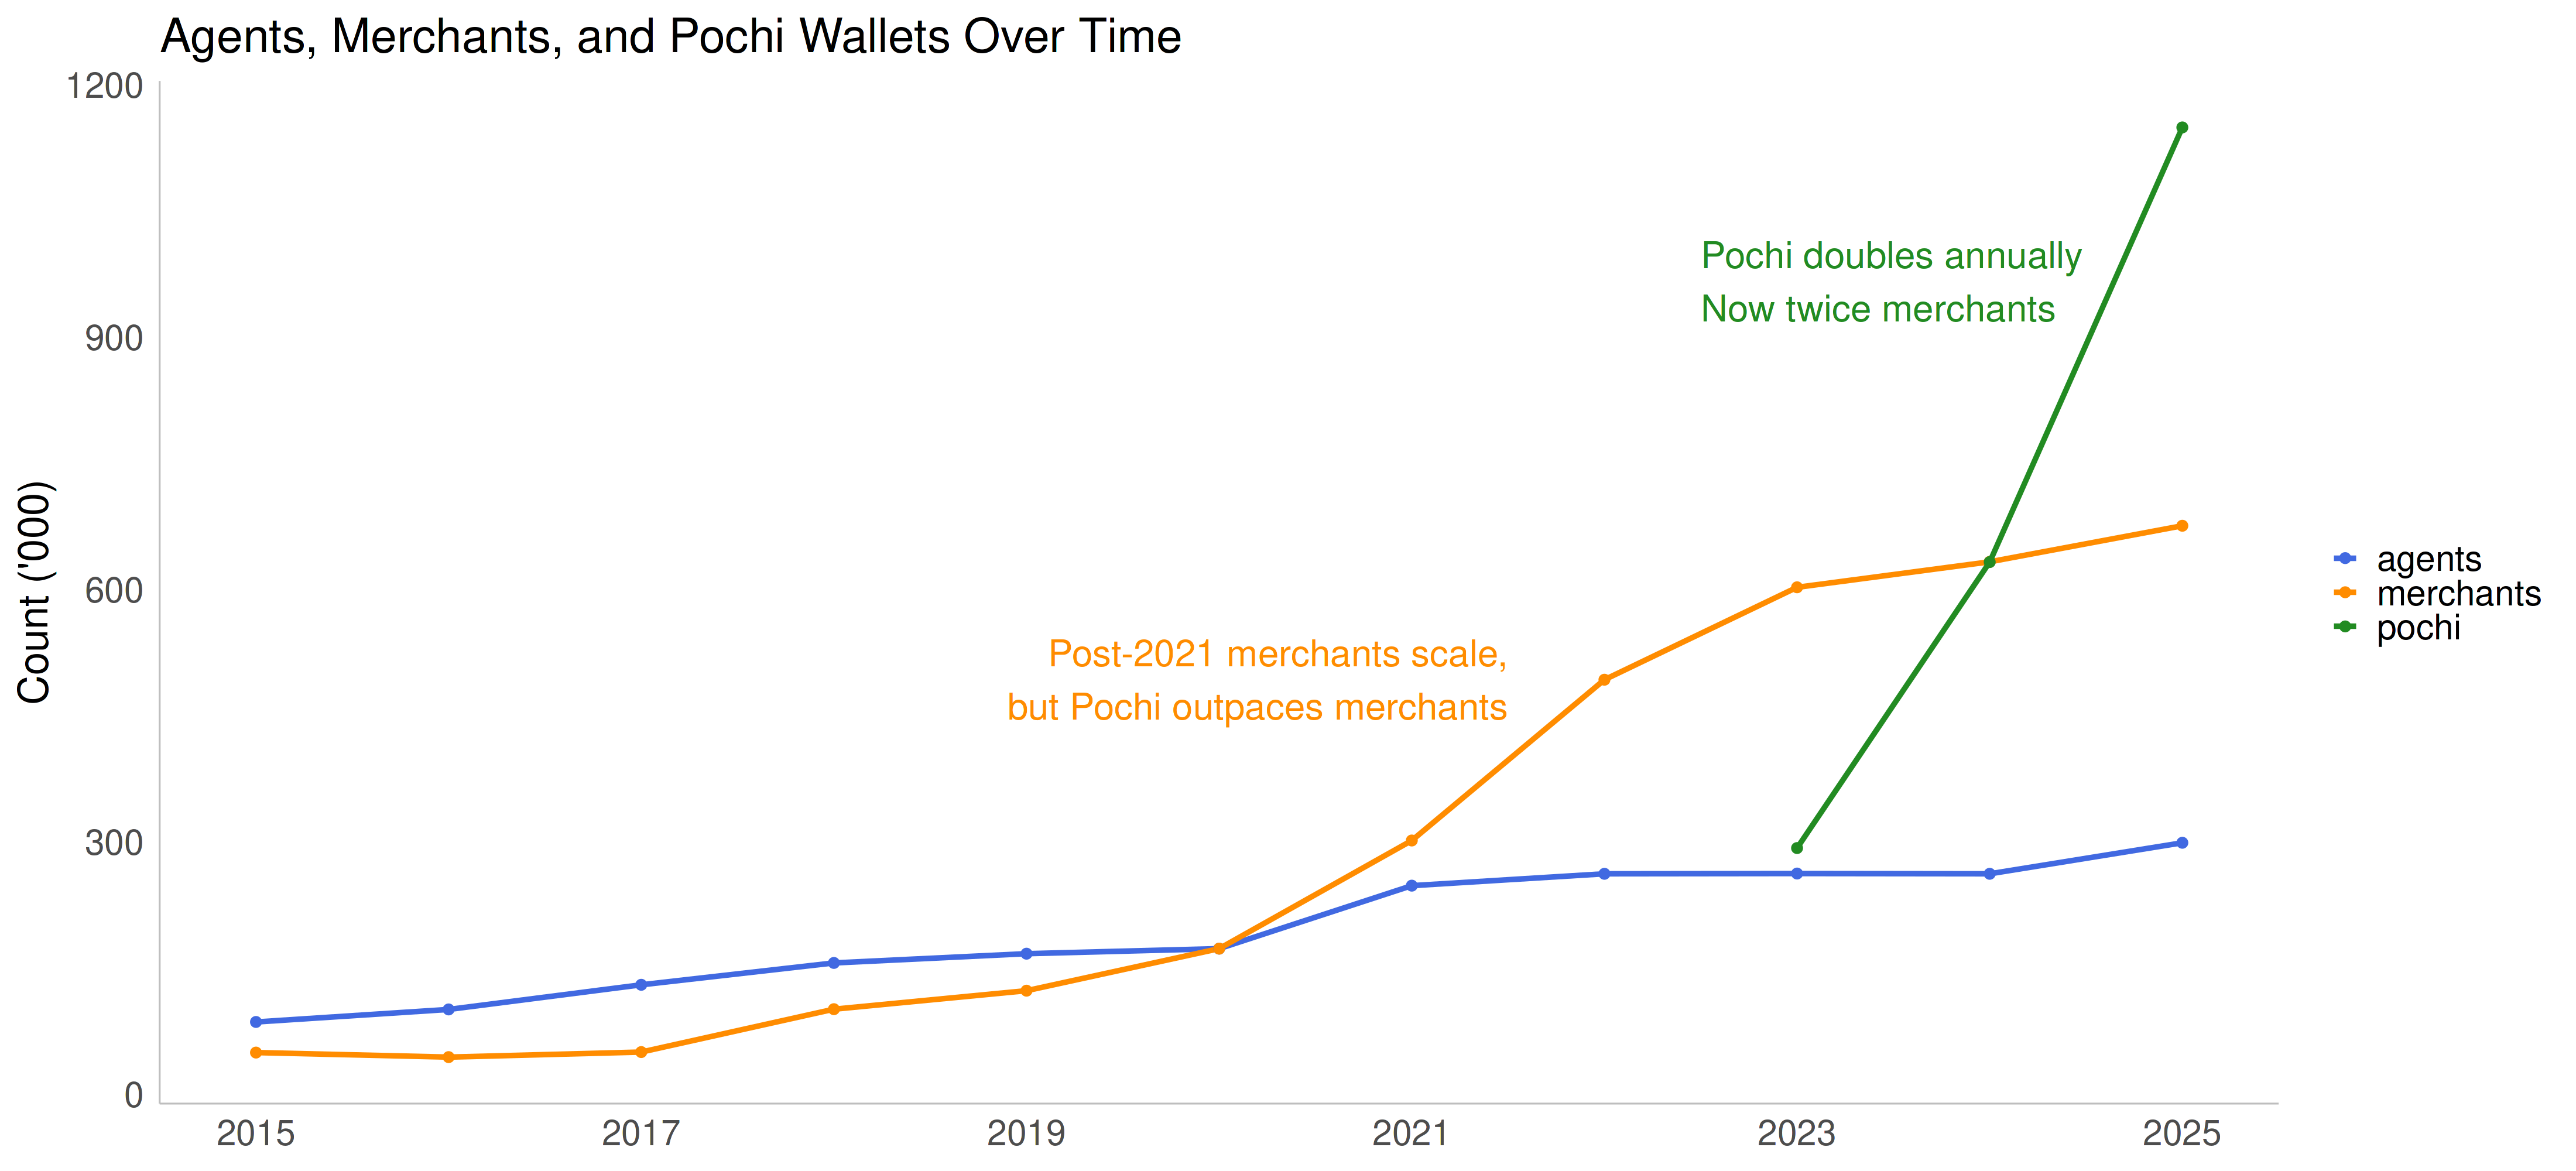

In [9]:
p8 + theme(plot.margin = margin(20, 20, 20, 20)) & 
  my_theme

Pochi has surged to become the fastest-growing part of M-Pesa’s network, doubling annually from 292.6K active users in 2023 to 1.15M in 2025—nearly twice the 675.9K merchants in 2025. This growth has outpaced agent expansion, which plateaued after 2020, while merchant enrollment accelerated more moderately. The network has clearly shifted from a cash-heavy agent infrastructure to merchant-led digital payments, with Pochi now driving the majority of micro-commerce flows that previously transacted through merchant rails.

## Recommendation Summary

1. **Prioritize Retention Over Acquisition** – With active user growth slowing to ~1% in 2023–2024, focus on loyalty programs and cross-selling financial products to maximize value from existing users.

2. **Target Micro-Transactions** – Average transaction size has declined sharply while volume continues to rise; optimize features for fast, reliable, low-value payments to capture high-frequency flows.

3. **Strengthen Pochi** – Pochi now has 1.15M active users, nearly twice the merchant base, and drives the majority of micro-commerce flows. Streamline onboarding, enhance usability, and embed Pochi deeper into the ecosystem.

4. **Expand to New Markets** – With M-Pesa revenue approaching maturity in Kenya, identify high-potential markets such as Ethiopia for expansion while sustaining strong domestic performance.

## Future Exploration
1. **Transaction Fees and Volume Dynamics** – Examine how different fee structures influence transaction frequency and value, identifying opportunities to optimize revenue without discouraging users.

2. **Market Share Analysis** – Compare Kenya’s mobile money and banking players to see who dominates, who is growing fastest, and what strategies (pricing, features, partnerships) they’re using to capture more customers.